In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine
from GTGP import GTGP


from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [3]:
df = pd.read_csv("../data/confidence.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

seeds = [10086, 200,500,30506,30405,30420,10056,7059,40965,5398,869543,83491,823190,
         48392,2810,48392,3498210,483902,859032,12890,538920,86954,54309,6504,9840,
         219805,548,2981,432890,5438908,219094,5843902,60854,979,12890,2108,4093]
train_size = 0.7
dataset = 'confidence'

In [4]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

# model

In [5]:
def fit_trees(tolerance = 0.001,max_nodes=1000):
    learning_rate=1
    max_depth=1
    bins=5
    lam=10

    gtgp = GTGP(learning_rate=learning_rate,max_depth=max_depth,bins=bins,lam=lam)

    total_size=10
    elite_size = 10
    epoch= 10
    gp_epoch= 3
    verbose = 1

    gtgp.fit_fixed_number(X_train,y_train,total_size=total_size,elite_size = elite_size,
                          epoch=epoch,gp_epoch=gp_epoch,tolerance=tolerance,max_nodes=max_nodes,verbose=verbose)
    # gtgp.fit(X_train,y_train,total_size=total_size,elite_size = elite_size,epoch=epoch,gp_epoch=gp_epoch,tolerance=tolerance,verbose=verbose)

    # retrain_epoch= max(3000//sum([tree.numNode for tree in gtgp.stack]),1)
    retrain_epoch = 5

    alpha=0
    beta=1
    gammer=0

    verbose=1
    gtgp.lam = 10
    gtgp.retrain_estimators(X_test,y_test,retrain_epoch=retrain_epoch,alpha=alpha,beta=beta,gammer=gammer,verbose=verbose)

    return gtgp


test_sses = []
test_accs = []

tors = [0,1e-12,1e-4,1e-2]
# tors = [1e-2]
for t in tors:
    test_sse = []
    test_acc = []
    for i in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
        y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

        gtgp = fit_trees(tolerance=t,max_nodes=100)
        num_trees,depth,num_nodes = gtgp.print_model()
        test_sse.append(gtgp.test_sse)
        test_acc.append(gtgp.test_acc)
    min_epoch = min([len(t) for t in test_acc])
    test_sses.append(test_sse)
    test_accs.append(test_acc)

30 172 1
retrain  1 :
	train: 0.84 0.7693602693602694 	test: 0.7727272727272727 0.7454212454212454
retrain  2 :
	train: 0.84 0.7693602693602694 	test: 0.7727272727272727 0.7454212454212454
retrain  3 :
	train: 0.84 0.7693602693602694 	test: 0.7727272727272727 0.7454212454212454
retrain  4 :
	train: 0.84 0.7693602693602694 	test: 0.7727272727272727 0.7454212454212454
retrain  5 :
	train: 0.84 0.7693602693602694 	test: 0.7727272727272727 0.7454212454212454
----------------GTGP-------------
Number of Trees: 30
Average of depth: 1.7666666666666666
Number of nodes: 172
30 182 1
retrain  1 :
	train: 0.66 0.5413071895424837 	test: 0.5454545454545454 0.47179487179487173
retrain  2 :
	train: 0.66 0.5413071895424837 	test: 0.5454545454545454 0.47179487179487173
retrain  3 :
	train: 0.66 0.5413071895424837 	test: 0.5454545454545454 0.47179487179487173
retrain  4 :
	train: 0.66 0.5413071895424837 	test: 0.5454545454545454 0.47179487179487173
retrain  5 :
	train: 0.66 0.5413071895424837 	test: 0.54

In [47]:
[len(t) for t in test_sses]

[30, 30, 30, 30]

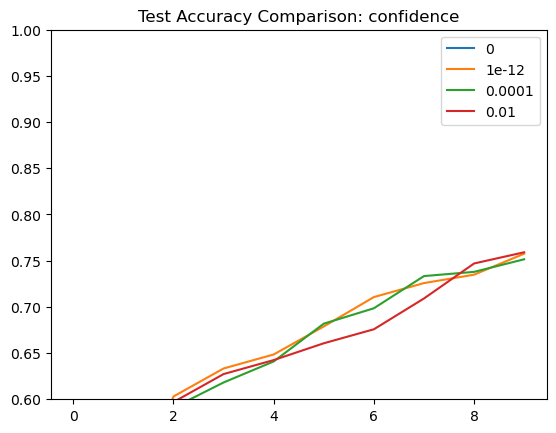

In [60]:
length = 10
test_acc_avgs = []
for t in test_accs:
    avg = []
    # length = min([len(i) for i in t])
    for i in range(length):
        avg.append(np.average([x[i] for x in t]))
    test_acc_avgs.append(avg)

for i in range(len(test_acc_avgs)):
    plt.plot(test_acc_avgs[i])
    # plt.plot(test_sses[i][:min_epoch])

# plt.yscale('log')
plt.title("Test Accuracy Comparison: "+dataset)
plt.ylim(0.6,1)
plt.legend(tors[:len(test_sses)])
plt.show()


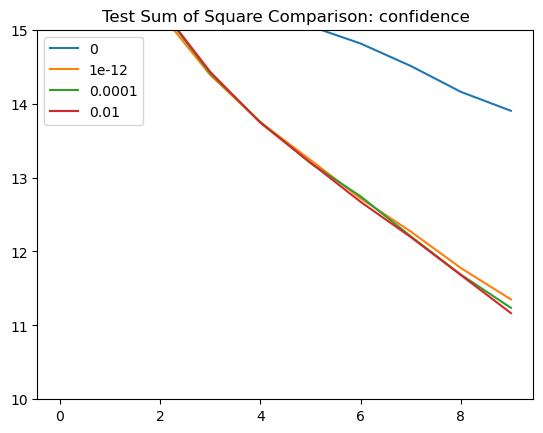

In [61]:
length = 10
test_sse_avg = []
for t in test_sses:
    avg = []
    for i in range(length):
        avg.append(np.average([x[i] for x in t]))
    test_sse_avg.append(avg)

for i in range(len(test_sse_avg)):
    plt.plot(test_sse_avg[i])
    # plt.plot(test_sses[i][:min_epoch])

# plt.yscale('log')

plt.title("Test SSE: "+dataset)
plt.ylim(10,15)
plt.title("Test Sum of Square Comparison: "+dataset)
plt.legend(tors[:len(test_sses)])
plt.show()
